# Anomaly Detection using Keras

***

## Evaluation

***

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [1]:
# Numerical arrays.
import numpy as np

# Spreadsheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

# Magic function 
%matplotlib inline

# Change default style sheet
plt.style.use('fivethirtyeight')

# Seaborn plots
import seaborn as sns

## Data

***

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

In [5]:
# Read a comma-separated values (csv) file into DataFrame.
# Use "timestamp" as the row labels of the DataFrame.
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# Return the first n rows (5 by default).
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# Generate descriptive statistics.
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


After using `df_small_noise.head()`, pandas seems to have rounded the first value in the DataFrame. If we look at the first value in the csv file, it's 18.324918539200002. This could be a problem later on so let's investigate this.

In [8]:
# Use iloc for integer-location based indexing. Selection by position.
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [9]:
# Ask pandas for the 'value' column.
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# Return the 0th value of the DataFrame (does the same thing as above).
df_small_noise.iloc[0].values[0]

18.3249185392

The value seems to be rounded when we print the individual value. It wasn't rounded as much as when we used `df_small_noise.head()`. Below we can multiply by a big number to see if jupyter will display the trailing values.

In [11]:
# Multiply by 10e12 to see if we can see the missing values.
df_small_noise.iloc[0].values[0] * 10e12

183249185392000.0

The missing values are still not being printed. The missing digits are so small however that we probably will not see any effect.

In [12]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_small_noise.shape

(4032, 1)

The DataFrame has 2 dimensions. It has 4032 rows if we do not include the header rows. This matches the raw csv which has 4033 including the header row.

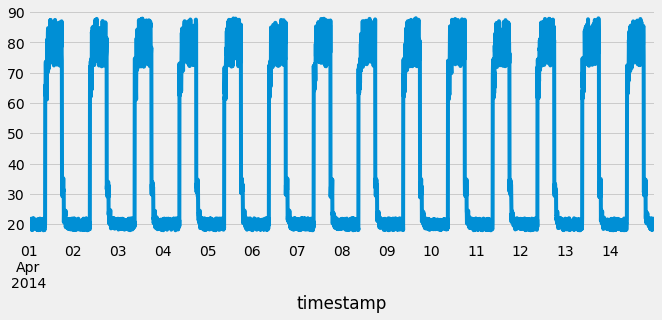

In [13]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax);

In [14]:
# Read a comma-separated values (csv) file into DataFrame.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [15]:
# Return the first n rows (5 by default).
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [16]:
# Generate descriptive statistics.
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [17]:
# Ask pandas for the 'value' column.
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [18]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_daily_jumpsup.shape

(4032, 1)

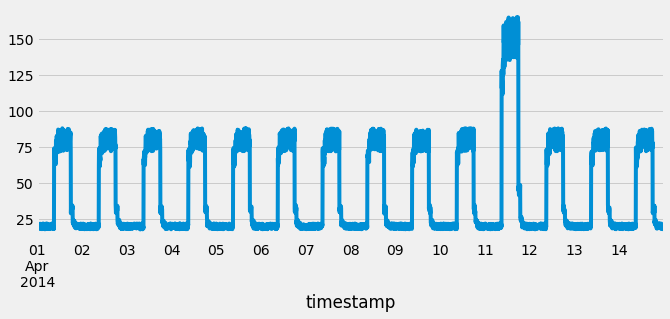

In [19]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

## Preprocessing

***

In [20]:
# Get the mean.
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [21]:
# Get the standard deviation.
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [22]:
# Subtract the mean from each value in the DataFrame and divide that value by the standard deviation.
df_train_vals = (df_small_noise - train_mean) / train_std

In [23]:
# Return the first n rows (5 by default).
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [24]:
# Create a new column 'less_mean' which is the result of subtracting the mean from each value 
# in the DataFrame
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()

# Create a new column 'div_std' which is the result of dividing the 'less_mean' by the 
# standard deviation.
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [25]:
# Take a look at the new columns in 'df_small_noise'
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [26]:
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.43835333580657, 5.018912974813406e-15, 1.691768418476429e-16)

In [27]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.07712228126252, 28.077122281262515, 0.9999999999999999)

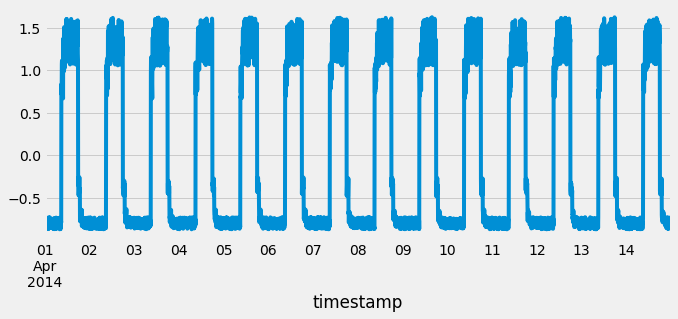

In [28]:
# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

In [29]:
# Returns a tuple that shows how many dimension the DataFrame has.
df_train_vals.shape

(4032, 1)

In [30]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [31]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [32]:
# Remove brackets.
len(L) - win_size + 1

10

In [33]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])


[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [34]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [35]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [36]:
# Window size for the DataFrame.
window_size = 288

In [37]:
# Function to generate the windows in the DataFrame.
def windows(vals, N=window_size):
  # 
  L = []
  # 
  for i in range(len(vals) - N + 1):
    # 
    L.append(vals[i:i+N])
  # Stack
  return np.stack(L)

In [38]:
# Use def windows to generate the training data for x.
x_train = windows(df_train_vals)

In [39]:
# Look at the first and last values in x_train using indexing.
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [40]:
# Look at the first and last values in x_train using iloc.
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [41]:
# Returns a tuple that shows how many dimension the DataFrame has.
x_train.shape

(3745, 288, 1)

In [42]:
# Ask pandas for the 'value' column and use '.values' to return a Numpy representation of the DataFrame.
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [43]:
# Look at the first element (window) of 'x_train' and use 'flatten' to return 
# a copy of the array collapsed into one dimension.
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

Recreate the same plot of df_train_vals as above but with more control over it than we have above.

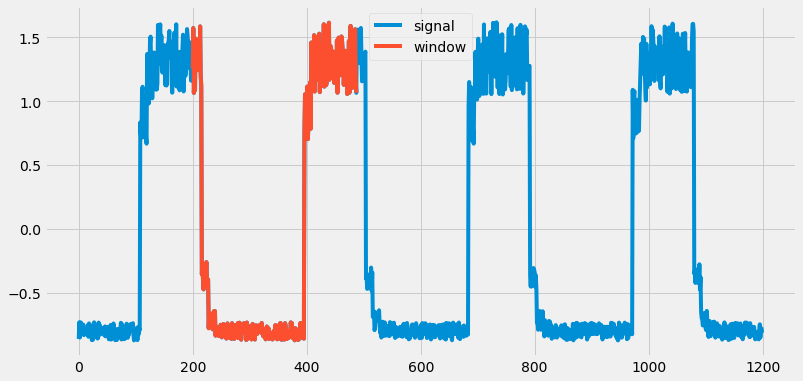

In [44]:
# Change this value to look at different windows.
window_no = 200

# Shortcut for initializing a figure and subplot axes.
fig, ax = plt.subplots(figsize=(12, 6))

# y values are pulled from the 'df_train_vals' DF.
y = df_train_vals['value'].values[:1200]

# We want x values that are spaced out by the same interval as the y values.
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
w = x_train[window_no].flatten()

# plot DataFame.
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

## Neural Network

In [45]:
x_train.shape

(3745, 288, 1)

In [46]:
#
layers = [
  #
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [47]:
#
model = keras.Sequential(layers)

In [48]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [49]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [51]:
# 
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
27/27 [==============================] - 2s 32ms/step - loss: 0.5203 - val_loss: 0.0550
Epoch 2/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0802 - val_loss: 0.0419
Epoch 3/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0575 - val_loss: 0.0358
Epoch 4/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0480 - val_loss: 0.0295
Epoch 5/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0417 - val_loss: 0.0261
Epoch 6/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0371 - val_loss: 0.0247
Epoch 7/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0335 - val_loss: 0.0221
Epoch 8/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0304 - val_loss: 0.0201
Epoch 9/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0277 - val_loss: 0.0189
Epoch 10/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0261 - val_loss: 0.0194
Epoch 11/

## Evaluation

***

In [52]:
history.history["loss"]

[0.5202952027320862,
 0.08019455522298813,
 0.05749987065792084,
 0.04804003983736038,
 0.04165344312787056,
 0.037064824253320694,
 0.03350480645895004,
 0.030366722494363785,
 0.02774510346353054,
 0.02611313946545124,
 0.02453131228685379,
 0.023318573832511902,
 0.022204652428627014,
 0.02122686058282852,
 0.020467469468712807,
 0.019558502361178398,
 0.018683677539229393,
 0.017974073067307472,
 0.017177846282720566,
 0.01650717481970787,
 0.01573498174548149,
 0.015165852382779121,
 0.014437953010201454,
 0.013897379860281944,
 0.013311455026268959,
 0.012827166356146336,
 0.012412721291184425,
 0.011997239664196968,
 0.011532875709235668,
 0.011156553402543068,
 0.010783500969409943,
 0.010447791777551174,
 0.010102570988237858,
 0.009813917800784111,
 0.009456031955778599,
 0.009236257523298264,
 0.008942282758653164,
 0.008734367787837982,
 0.008542385883629322,
 0.008250481449067593,
 0.008059116080403328,
 0.007928543724119663,
 0.007772872224450111,
 0.0075650145299732685,


In [53]:
history.history["val_loss"]

[0.054951928555965424,
 0.041940297931432724,
 0.035840943455696106,
 0.02950367145240307,
 0.026120951399207115,
 0.024731308221817017,
 0.022112281993031502,
 0.020083913579583168,
 0.01886463351547718,
 0.019387122243642807,
 0.01938895508646965,
 0.01882244274020195,
 0.01917911320924759,
 0.01915919780731201,
 0.01817088946700096,
 0.018513064831495285,
 0.018268732354044914,
 0.017460022121667862,
 0.018887069076299667,
 0.0180123969912529,
 0.015982424840331078,
 0.01655767671763897,
 0.01582486182451248,
 0.01555707398802042,
 0.015011752024292946,
 0.015479966066777706,
 0.013816788792610168,
 0.0129087520763278,
 0.012161011807620525,
 0.013110007159411907,
 0.011310991831123829,
 0.011133830063045025,
 0.01178787276148796,
 0.010909225791692734,
 0.010129095986485481,
 0.008930756710469723,
 0.009126689285039902,
 0.008710576221346855,
 0.00875032413750887,
 0.008364520035684109,
 0.007955117151141167,
 0.007722306065261364,
 0.007029586937278509,
 0.007266804575920105,
 0.0

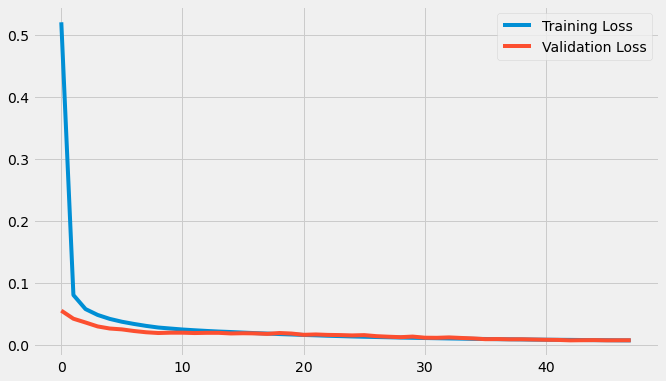

In [54]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

In [55]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 0s 3ms/step


In [56]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

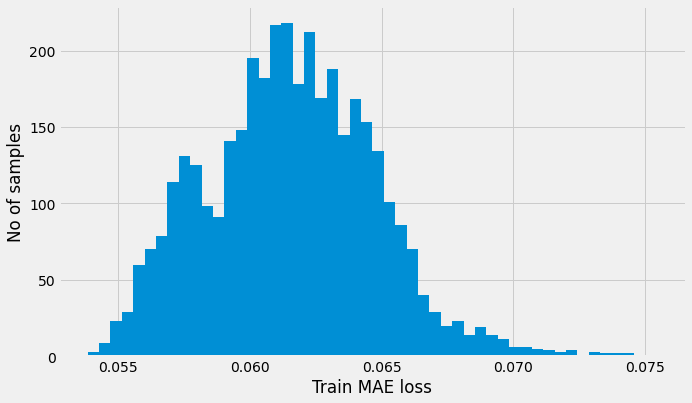

In [57]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [58]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# 
threshold

0.07545965667426847

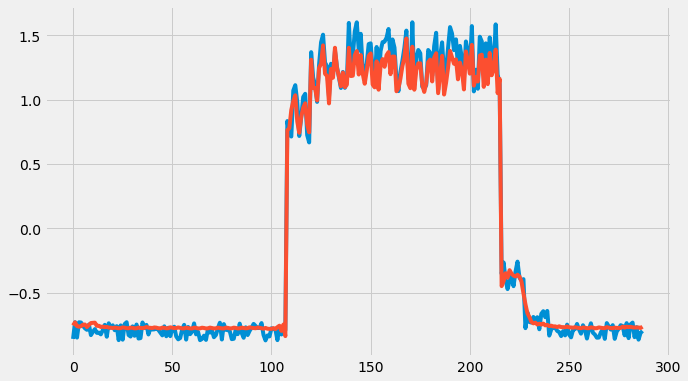

In [59]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [60]:
# 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

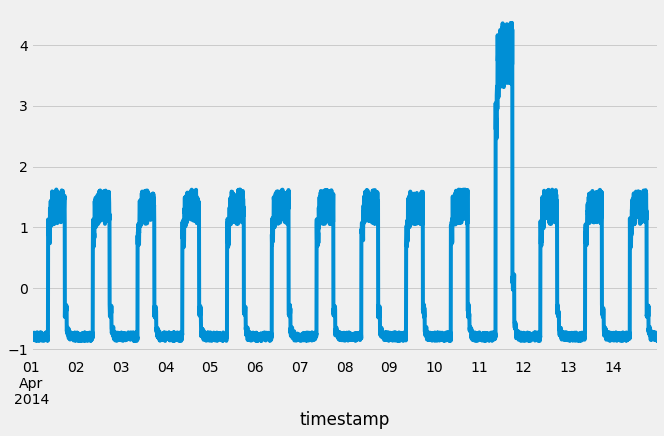

In [61]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);

In [62]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [63]:
# 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 3ms/step


In [64]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.06151581],
       [0.06044581],
       [0.06244584],
       ...,
       [0.06147136],
       [0.06437658],
       [0.06310797]])

In [65]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.06151581, 0.06044581, 0.06244584, ..., 0.06147136, 0.06437658,
       0.06310797])

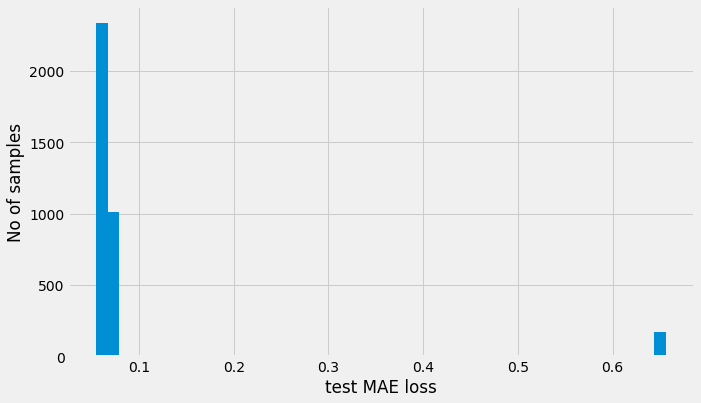

In [66]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [67]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# NUmber of anomalies.
np.sum(anomalies)

420

In [68]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [69]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

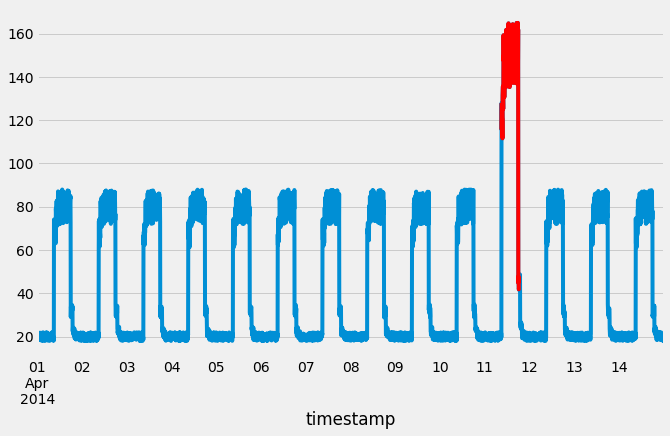

In [70]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");

***

## References

***

[01] []()<br>
[02] []()<br>
[03] []()<br>
[04] []()<br>
[05] []()<br>
[06] []()<br>
[07] []()<br>
[08] []()<br>
[09] []()<br>
[10] []()<br>
[11] []()<br>
[12] []()<br>
[14] []()<br>
[15] []()<br>